#Fairness-Aware Job-Matching: Semi-Supervised Learning for Gender Inference from Unformatted CV Embeddings Demo

##This notebook demonstrates the first component of the fairness-aware job-matching framework, using Semi-supervised VAE with teacher-student learning for gender inference in CV embeddings.


Environment Setup

In [2]:
print("Setting up environment...")
# Install required packages for GPU training
!pip install scikit-learn pandas numpy scipy matplotlib seaborn plotly -q
!pip install pydantic-settings ranx faiss-cpu -q

# Install PyTorch with CUDA support (compatible versions)
!pip uninstall torch torchvision torchaudio -y -q
!pip install torch torchvision torchaudio -q

# Mount Google Drive and setup paths
from google.colab import drive
drive.mount('/content/drive')

import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")

# Add framework to path
sys.path.append('/content/drive/MyDrive/Thesis/fairness_aware_job_matching/')

# Import framework components
from fairness_framework import (
    Config,
    ModelConfig,
    load_embeddings,
    load_oracle_data,
    prepare_data_with_oracle,
    VAE_Gender,
    train_baseline_vae,
    extract_latent_attributes,
    ImprovedSemiSupervisedVAE,
    run_semi_supervised_gender_vae_fixed
)

# Import specific functions that
from fairness_framework.models.semi_supervised_vae import (
    evaluate_gender_inference,
    train_semi_supervised_vae_improved,
    extract_semi_supervised_predictions
)
def set_thesis_style():
    sns.set(style='whitegrid', font_scale=1.1)
    plt.rcParams.update({
        'axes.edgecolor': 'black',
        'axes.linewidth': 1.0,
        'figure.dpi': 100,
        'savefig.bbox': 'tight',
        'legend.frameon': True,
        'legend.loc': 'best'
    })

set_thesis_style()
print("Environment setup complete.")

Setting up environment...
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.3/99.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.2/249.2 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.1/866.1 kB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.0/135.0 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━

Configuration and Data loading

In [3]:
# Update configuration for Colab environment
Config.update_base_path("/content/drive/MyDrive/Thesis/")
Config.PROPRIETARY_SRC_PATH = "/content/drive/MyDrive/Thesis/fine_tuning/src"
Config.PROPRIETARY_INFERENCE_PATH = "/content/drive/MyDrive/Thesis/fine_tuning/inference_endpoint/src"

# Add proprietary paths
sys.path.append(Config.PROPRIETARY_SRC_PATH)
sys.path.append(Config.PROPRIETARY_INFERENCE_PATH)

# Load data components
print("Loading embeddings and oracle data...")
embeddings, candidate_indices = load_embeddings()
oracle_df = load_oracle_data()
valid_embeddings, valid_indices, valid_genders = prepare_data_with_oracle(
    embeddings, candidate_indices, oracle_df
)

print(f"\nData Summary:")
print(f"  Original embeddings shape: {embeddings.shape}")
print(f"  Valid embeddings shape: {valid_embeddings.shape}")
print(f"  Embedding dimension: {valid_embeddings.shape[1]}")
print(f"  Total candidates with gender labels: {len(valid_genders)}")
print(f"  Female candidates: {np.sum(valid_genders == 0)} ({np.sum(valid_genders == 0)/len(valid_genders)*100:.1f}%)")
print(f"  Male candidates: {np.sum(valid_genders == 1)} ({np.sum(valid_genders == 1)/len(valid_genders)*100:.1f}%)")

# Split data for training and testing
print("\nSplitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(
    valid_embeddings, valid_genders,
    test_size=0.2,
    random_state=42,
    stratify=valid_genders
)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
all_data_tensor = torch.FloatTensor(valid_embeddings).to(device)

print(f"Training set: {X_train_tensor.shape}")
print(f"Testing set: {X_test_tensor.shape}")
print(f"Train gender distribution: Female={np.sum(y_train == 0)}, Male={np.sum(y_train == 1)}")
print(f"Test gender distribution: Female={np.sum(y_test == 0)}, Male={np.sum(y_test == 1)}")

# Clear CUDA cache
torch.cuda.empty_cache()

Loading embeddings and oracle data...
Loaded embeddings with shape: (10170, 1024)
Loaded oracle data with 10170 entries
Aligning candidate indices with oracle data...
Found 10013 candidates with valid gender labels
Valid embeddings shape: (10013, 1024)
Gender distribution: Female=4430, Male=5583

Data Summary:
  Original embeddings shape: (10170, 1024)
  Valid embeddings shape: (10013, 1024)
  Embedding dimension: 1024
  Total candidates with gender labels: 10013
  Female candidates: 4430 (44.2%)
  Male candidates: 5583 (55.8%)

Splitting data into training and testing sets...
Training set: torch.Size([8010, 1024])
Testing set: torch.Size([2003, 1024])
Train gender distribution: Female=3544, Male=4466
Test gender distribution: Female=886, Male=1117


Baseline VAE training

Training baseline VAE for comparison...
This establishes the performance without teacher guidance.
Training baseline VAE for CV embeddings
Baseline Epoch 10/100
  Train Loss: 1.1693
  Test Loss: 1.1002
  Test Accuracy: 0.5552
  KL Weight: 0.40
Baseline Epoch 20/100
  Train Loss: 1.1692
  Test Loss: 1.1001
  Test Accuracy: 0.5502
  KL Weight: 0.80
Baseline Epoch 30/100
  Train Loss: 1.1693
  Test Loss: 1.1001
  Test Accuracy: 0.5597
  KL Weight: 1.00
Baseline Epoch 40/100
  Train Loss: 1.1687
  Test Loss: 1.1001
  Test Accuracy: 0.5587
  KL Weight: 1.00
Baseline Epoch 50/100
  Train Loss: 1.1689
  Test Loss: 1.1001
  Test Accuracy: 0.5567
  KL Weight: 1.00
Baseline Epoch 60/100
  Train Loss: 1.1687
  Test Loss: 1.1001
  Test Accuracy: 0.5572
  KL Weight: 1.00
Baseline Epoch 70/100
  Train Loss: 1.1685
  Test Loss: 1.1001
  Test Accuracy: 0.5577
  KL Weight: 1.00
Baseline Epoch 80/100
  Train Loss: 1.1682
  Test Loss: 1.1001
  Test Accuracy: 0.5577
  KL Weight: 1.00
Baseline Epoch 90/100

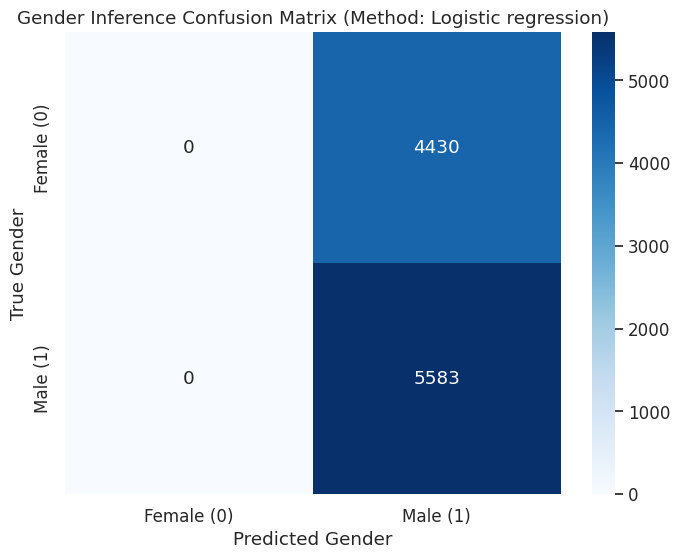

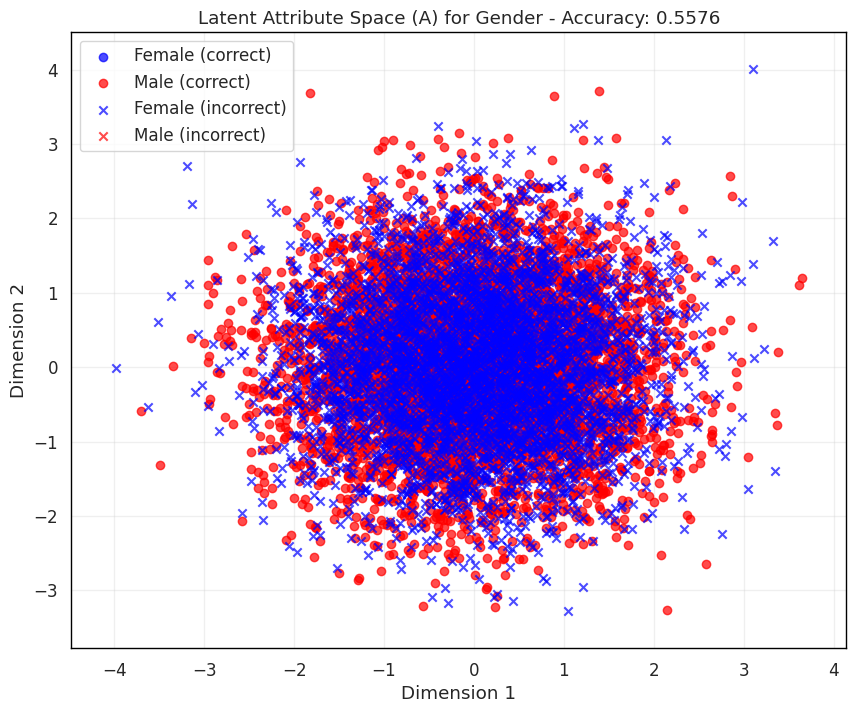


BASELINE VAE RESULTS:
  Accuracy: 0.5576
  F1 Score: 0.7160


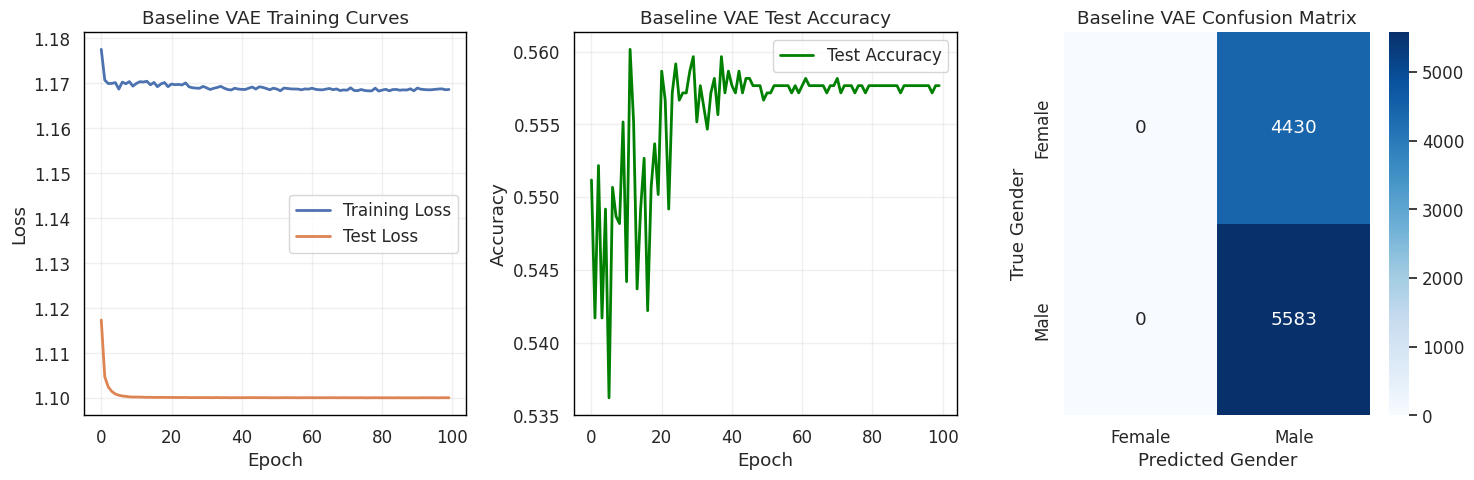

In [4]:
print("Training baseline VAE for comparison...")
print("This establishes the performance without teacher guidance.")

# Train baseline VAE
baseline_vae, baseline_train_losses, baseline_test_losses, baseline_test_accuracies = train_baseline_vae(
    X_train_tensor, y_train, X_test_tensor, y_test,
    num_epochs=100,
    batch_size=32,
    learning_rate=0.0002,
    device=device
)

print(f"\nBaseline VAE training completed.")
print(f"Final test accuracy: {baseline_test_accuracies[-1]:.4f}")

# Extract baseline latent representations
print("Extracting baseline latent attributes...")
baseline_latent_a = extract_latent_attributes(baseline_vae, all_data_tensor, device)

# Evaluate baseline performance
print("\nEvaluating baseline VAE performance...")
baseline_predictions, baseline_accuracy, baseline_f1, baseline_conf_matrix = evaluate_gender_inference(
    baseline_latent_a, valid_genders
)

print(f"\nBASELINE VAE RESULTS:")
print(f"  Accuracy: {baseline_accuracy:.4f}")
print(f"  F1 Score: {baseline_f1:.4f}")

# Plot baseline training curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(baseline_train_losses, label='Training Loss', linewidth=2)
plt.plot(baseline_test_losses, label='Test Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Baseline VAE Training Curves')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(baseline_test_accuracies, label='Test Accuracy', color='green', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Baseline VAE Test Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
sns.heatmap(baseline_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'])
plt.title('Baseline VAE Confusion Matrix')
plt.ylabel('True Gender')
plt.xlabel('Predicted Gender')

plt.tight_layout()
plt.show()

Semi-Supervised VAE Training

Training semi-supervised VAE with teacher classifier guidance...
This approach uses a supervised teacher to guide the VAE training.
Training teacher classifier with cross-validation...
Cross-validation results:
  C=0.1: CV Accuracy = 0.9579 (+/- 0.0068)
  C=1.0: CV Accuracy = 0.9478 (+/- 0.0114)
  C=10.0: CV Accuracy = 0.9477 (+/- 0.0108)
Best C value: 0.1 with CV accuracy: 0.9579
Teacher CV accuracy: 0.9579
Teacher train accuracy: 0.9873
Difference (overfitting indicator): 0.0293
1. Training Teacher Classifier
Training teacher classifier with cross-validation...
Cross-validation results:
  C=0.1: CV Accuracy = 0.9579 (+/- 0.0068)
  C=1.0: CV Accuracy = 0.9478 (+/- 0.0114)
  C=10.0: CV Accuracy = 0.9477 (+/- 0.0108)
Best C value: 0.1 with CV accuracy: 0.9579
Teacher CV accuracy: 0.9579
Teacher train accuracy: 0.9873
Difference (overfitting indicator): 0.0293
2. Training Semi-Supervised VAE


Training Semi-Supervised VAE:   1%|          | 1/150 [00:03<08:58,  3.61s/it]

New best accuracy: 0.5686
Epoch 1/150
  Train Loss: 0.8631
  Consistency Loss: 0.6665
  Test Loss: 1.1923
  Test Accuracy: 0.5686
  KL Weight: 0.03
  Consistency Weight: 0.05
  Current LR: 0.000200


Training Semi-Supervised VAE:   1%|▏         | 2/150 [00:06<08:02,  3.26s/it]

New best accuracy: 0.8767
Epoch 2/150
  Train Loss: 0.8591
  Consistency Loss: 0.4961
  Test Loss: 1.5098
  Test Accuracy: 0.8767
  KL Weight: 0.05
  Consistency Weight: 0.06
  Current LR: 0.000200


Training Semi-Supervised VAE:   2%|▏         | 3/150 [00:09<07:31,  3.07s/it]

New best accuracy: 0.8792
Epoch 3/150
  Train Loss: 0.8581
  Consistency Loss: 0.2734
  Test Loss: 1.4391
  Test Accuracy: 0.8792
  KL Weight: 0.08
  Consistency Weight: 0.08
  Current LR: 0.000200


Training Semi-Supervised VAE:   3%|▎         | 4/150 [00:12<07:14,  2.98s/it]

New best accuracy: 0.8817
Epoch 4/150
  Train Loss: 0.8621
  Consistency Loss: 0.2279
  Test Loss: 1.4296
  Test Accuracy: 0.8817
  KL Weight: 0.11
  Consistency Weight: 0.09
  Current LR: 0.000200


Training Semi-Supervised VAE:   3%|▎         | 5/150 [00:15<07:20,  3.04s/it]

Epoch 5/150
  Train Loss: 0.8677
  Consistency Loss: 0.2204
  Test Loss: 1.3921
  Test Accuracy: 0.8702
  KL Weight: 0.14
  Consistency Weight: 0.10
  Current LR: 0.000200


Training Semi-Supervised VAE:   4%|▍         | 6/150 [00:18<07:29,  3.12s/it]

New best accuracy: 0.8862


Training Semi-Supervised VAE:   5%|▍         | 7/150 [00:21<07:11,  3.02s/it]

New best accuracy: 0.8877


Training Semi-Supervised VAE:   5%|▌         | 8/150 [00:24<07:00,  2.96s/it]

New best accuracy: 0.8917


Training Semi-Supervised VAE:   7%|▋         | 10/150 [00:30<07:16,  3.12s/it]

New best accuracy: 0.8932
Epoch 10/150
  Train Loss: 0.8999
  Consistency Loss: 0.2234
  Test Loss: 1.4298
  Test Accuracy: 0.8932
  KL Weight: 0.27
  Consistency Weight: 0.17
  Current LR: 0.000200


Training Semi-Supervised VAE:   7%|▋         | 11/150 [00:33<07:04,  3.05s/it]

New best accuracy: 0.9006


Training Semi-Supervised VAE:  13%|█▎        | 20/150 [01:00<06:29,  3.00s/it]

Epoch 20/150
  Train Loss: 0.9658
  Consistency Loss: 0.2183
  Test Loss: 1.3648
  Test Accuracy: 0.8712
  KL Weight: 0.54
  Consistency Weight: 0.29
  Current LR: 0.000100


Training Semi-Supervised VAE:  15%|█▍        | 22/150 [01:06<06:14,  2.92s/it]

Epoch 22/150
  Train Loss: 0.9798
  Consistency Loss: 0.2204
  Test Loss: 1.4070
  Test Accuracy: 0.8962
  KL Weight: 0.59
  Consistency Weight: 0.32
  Current LR: 0.000100


Training Semi-Supervised VAE:  15%|█▌        | 23/150 [01:09<06:35,  3.12s/it]

Epoch 23/150
  Train Loss: 0.9823
  Consistency Loss: 0.2195
  Test Loss: 1.3491
  Test Accuracy: 0.8672
  KL Weight: 0.62
  Consistency Weight: 0.33
  Current LR: 0.000050


Training Semi-Supervised VAE:  16%|█▌        | 24/150 [01:12<06:33,  3.12s/it]

Epoch 24/150
  Train Loss: 0.9935
  Consistency Loss: 0.2185
  Test Loss: 1.3767
  Test Accuracy: 0.8947
  KL Weight: 0.65
  Consistency Weight: 0.35
  Current LR: 0.000050


Training Semi-Supervised VAE:  17%|█▋        | 25/150 [01:15<06:20,  3.04s/it]

Epoch 25/150
  Train Loss: 0.9984
  Consistency Loss: 0.2123
  Test Loss: 1.3541
  Test Accuracy: 0.8747
  KL Weight: 0.68
  Consistency Weight: 0.36
  Current LR: 0.000050


Training Semi-Supervised VAE:  17%|█▋        | 26/150 [01:18<06:09,  2.98s/it]

Epoch 26/150
  Train Loss: 1.0107
  Consistency Loss: 0.2223
  Test Loss: 1.3554
  Test Accuracy: 0.8777
  KL Weight: 0.70
  Consistency Weight: 0.37
  Current LR: 0.000050


Training Semi-Supervised VAE:  18%|█▊        | 27/150 [01:22<06:29,  3.17s/it]

Epoch 27/150
  Train Loss: 1.0137
  Consistency Loss: 0.2165
  Test Loss: 1.3665
  Test Accuracy: 0.8767
  KL Weight: 0.73
  Consistency Weight: 0.38
  Current LR: 0.000050


Training Semi-Supervised VAE:  19%|█▊        | 28/150 [01:25<06:13,  3.06s/it]

Epoch 28/150
  Train Loss: 1.0178
  Consistency Loss: 0.2178
  Test Loss: 1.3759
  Test Accuracy: 0.8817
  KL Weight: 0.76
  Consistency Weight: 0.40
  Current LR: 0.000050


Training Semi-Supervised VAE:  19%|█▉        | 29/150 [01:27<06:01,  2.99s/it]

Epoch 29/150
  Train Loss: 1.0206
  Consistency Loss: 0.2106
  Test Loss: 1.3592
  Test Accuracy: 0.8877
  KL Weight: 0.78
  Consistency Weight: 0.41
  Current LR: 0.000050


Training Semi-Supervised VAE:  20%|██        | 30/150 [01:30<05:54,  2.96s/it]

Epoch 30/150
  Train Loss: 1.0325
  Consistency Loss: 0.2071
  Test Loss: 1.3443
  Test Accuracy: 0.8752
  KL Weight: 0.81
  Consistency Weight: 0.42
  Current LR: 0.000050


Training Semi-Supervised VAE:  21%|██        | 31/150 [01:34<06:04,  3.06s/it]

Epoch 31/150
  Train Loss: 1.0417
  Consistency Loss: 0.2129
  Test Loss: 1.3640
  Test Accuracy: 0.8882
  KL Weight: 0.84
  Consistency Weight: 0.44
  Current LR: 0.000050


Training Semi-Supervised VAE:  21%|██▏       | 32/150 [01:37<06:04,  3.09s/it]

Epoch 32/150
  Train Loss: 1.0437
  Consistency Loss: 0.2121
  Test Loss: 1.3867
  Test Accuracy: 0.8997
  KL Weight: 0.86
  Consistency Weight: 0.45
  Current LR: 0.000050


Training Semi-Supervised VAE:  22%|██▏       | 33/150 [01:40<05:51,  3.00s/it]

Epoch 33/150
  Train Loss: 1.0523
  Consistency Loss: 0.2202
  Test Loss: 1.3616
  Test Accuracy: 0.8702
  KL Weight: 0.89
  Consistency Weight: 0.46
  Current LR: 0.000050


Training Semi-Supervised VAE:  23%|██▎       | 34/150 [01:42<05:42,  2.95s/it]

Epoch 34/150
  Train Loss: 1.0580
  Consistency Loss: 0.2151
  Test Loss: 1.3458
  Test Accuracy: 0.8692
  KL Weight: 0.92
  Consistency Weight: 0.47
  Current LR: 0.000025


Training Semi-Supervised VAE:  23%|██▎       | 35/150 [01:45<05:37,  2.94s/it]

Epoch 35/150
  Train Loss: 1.0643
  Consistency Loss: 0.2188
  Test Loss: 1.3580
  Test Accuracy: 0.8872
  KL Weight: 0.95
  Consistency Weight: 0.49
  Current LR: 0.000025


Training Semi-Supervised VAE:  23%|██▎       | 35/150 [01:49<05:59,  3.12s/it]

Epoch 36/150
  Train Loss: 1.0699
  Consistency Loss: 0.2196
  Test Loss: 1.3513
  Test Accuracy: 0.8707
  KL Weight: 0.97
  Consistency Weight: 0.50
  Current LR: 0.000025
Early stopping triggered at epoch 36 - no accuracy improvement for 25 epochs
Loaded best model with accuracy: 0.9006

Semi-supervised VAE training completed.
Final test accuracy: 0.8707
Extracting semi-supervised predictions...



Semi-supervised results:
  Teacher (supervised): 0.9796
  Bridge (semi-supervised): 0.9123

Detailed latent space analysis...
Evaluating gender inference with multiple methods...

Gender inference results:
  First dimension threshold: Accuracy = 0.5022, F1 = 0.5295
  Linear combination: Accuracy = 0.2855, F1 = 0.3192
  Logistic regression: Accuracy = 0.9145, F1 = 0.9232

Best method: Logistic regression
Accuracy: 0.9145
F1 Score: 0.9232
Precision: 0.9250
Recall: 0.9214


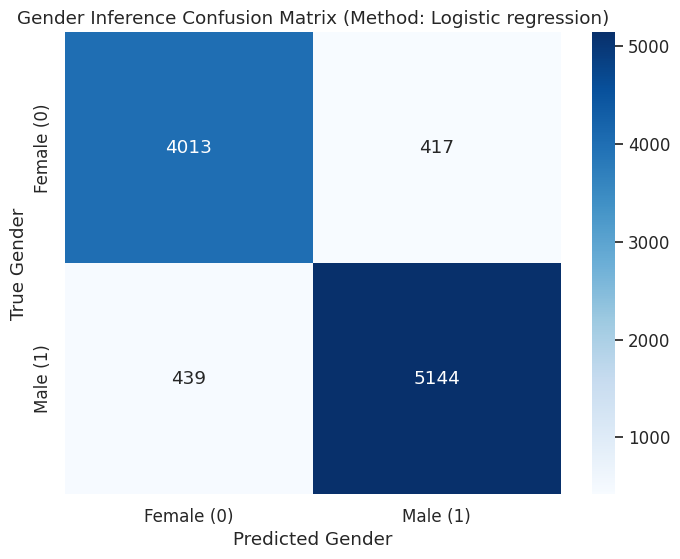

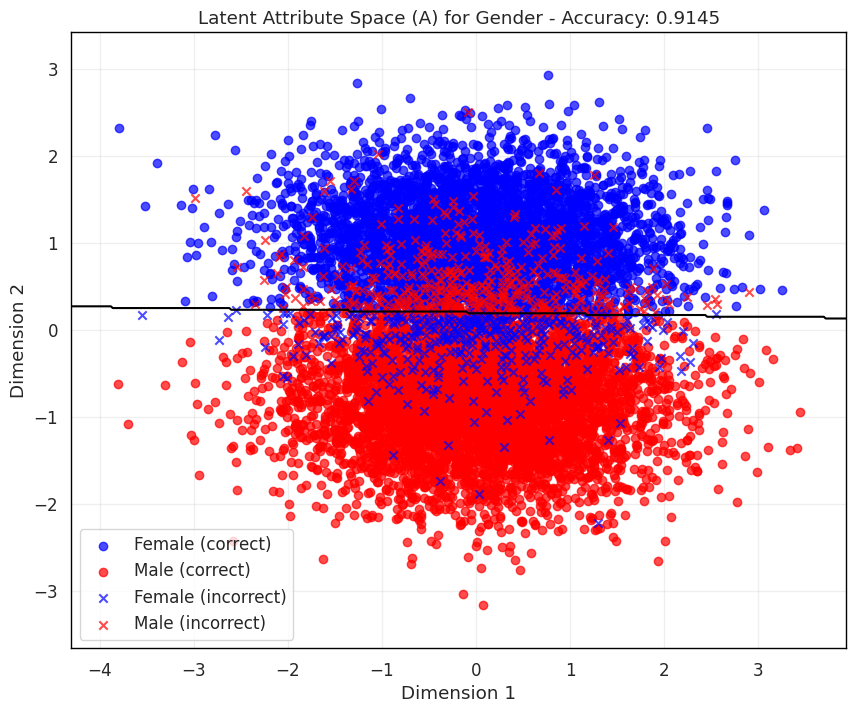

  Semi-supervised latent accuracy: 0.9145
  Semi-supervised latent F1: 0.9232


In [5]:
print("Training semi-supervised VAE with teacher classifier guidance...")
print("This approach uses a supervised teacher to guide the VAE training.")

# Train semi-supervised VAE
input_dim = X_train_tensor.shape[1]
semi_supervised_model = ImprovedSemiSupervisedVAE(
    feat_d=input_dim,
    feat_related_d=input_dim,
    label_dim=1,
    hidden_dim=ModelConfig.VAE_HIDDEN_DIM,
    z_dim=ModelConfig.VAE_Z_DIM,
    a_dim=ModelConfig.VAE_A_DIM,
    temperature=1.0,
    custom=True
).to(device)

# Import training function
from fairness_framework.models.semi_supervised_vae import (
    train_semi_supervised_vae_improved,
    extract_semi_supervised_predictions
)

teacher_acc = semi_supervised_model.train_teacher(X_train_tensor, y_train)

trained_model, ss_train_losses, ss_test_losses, ss_test_accuracies, consistency_losses = train_semi_supervised_vae_improved(
    semi_supervised_model, X_train_tensor, y_train, X_test_tensor, y_test,
    num_epochs=150,
    batch_size=32,
    learning_rate=0.0002
)

print(f"\nSemi-supervised VAE training completed.")
print(f"Final test accuracy: {ss_test_accuracies[-1]:.4f}")

# Extract semi-supervised predictions
print("Extracting semi-supervised predictions...")
semi_latent_a, gender_probs, teacher_probs = extract_semi_supervised_predictions(trained_model, all_data_tensor)

# Get predictions from different methods
bridge_preds = (gender_probs[:, 1] > 0.5).astype(int)
teacher_preds = (teacher_probs[:, 1] > 0.5).astype(int)

# Calculate accuracies
bridge_acc = accuracy_score(valid_genders, bridge_preds)
teacher_acc_full = accuracy_score(valid_genders, teacher_preds)

print(f"\nSemi-supervised results:")
print(f"  Teacher (supervised): {teacher_acc_full:.4f}")
print(f"  Bridge (semi-supervised): {bridge_acc:.4f}")

# Detailed evaluation of semi-supervised latent space
print("\nDetailed latent space analysis...")
semi_predictions, semi_accuracy, semi_f1, semi_conf_matrix = evaluate_gender_inference(
    semi_latent_a, valid_genders
)

print(f"  Semi-supervised latent accuracy: {semi_accuracy:.4f}")
print(f"  Semi-supervised latent F1: {semi_f1:.4f}")

Latent Space Analysis

Analyzing learned latent representations...


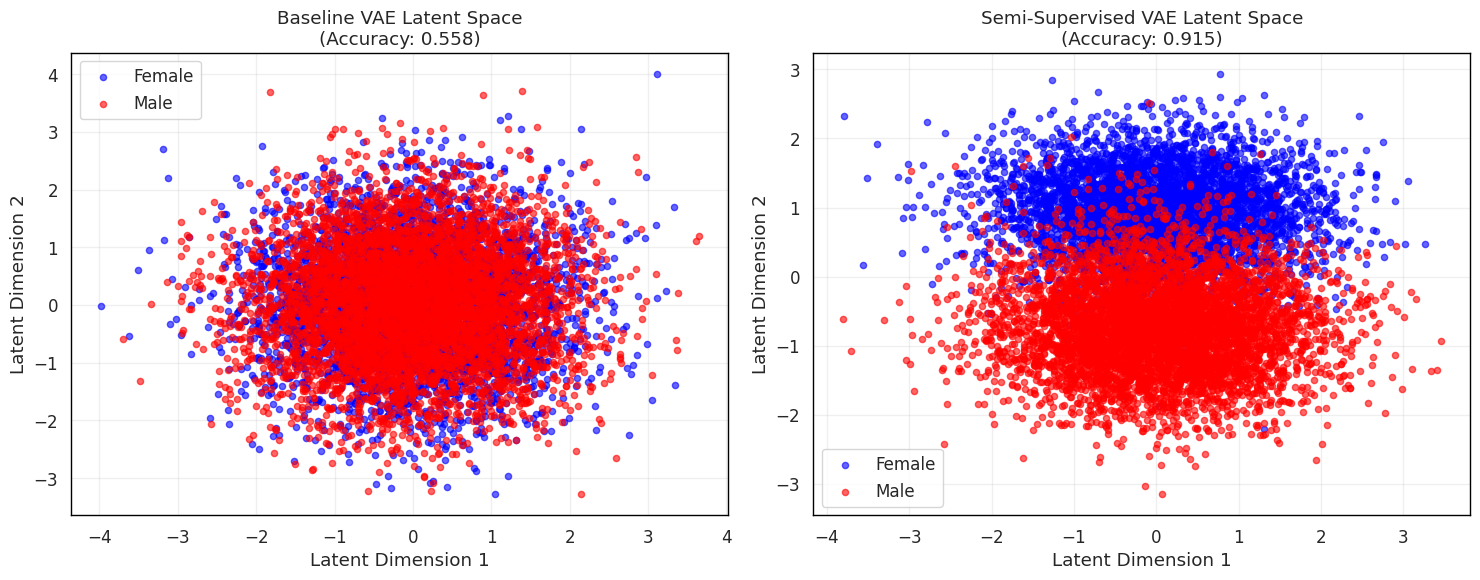

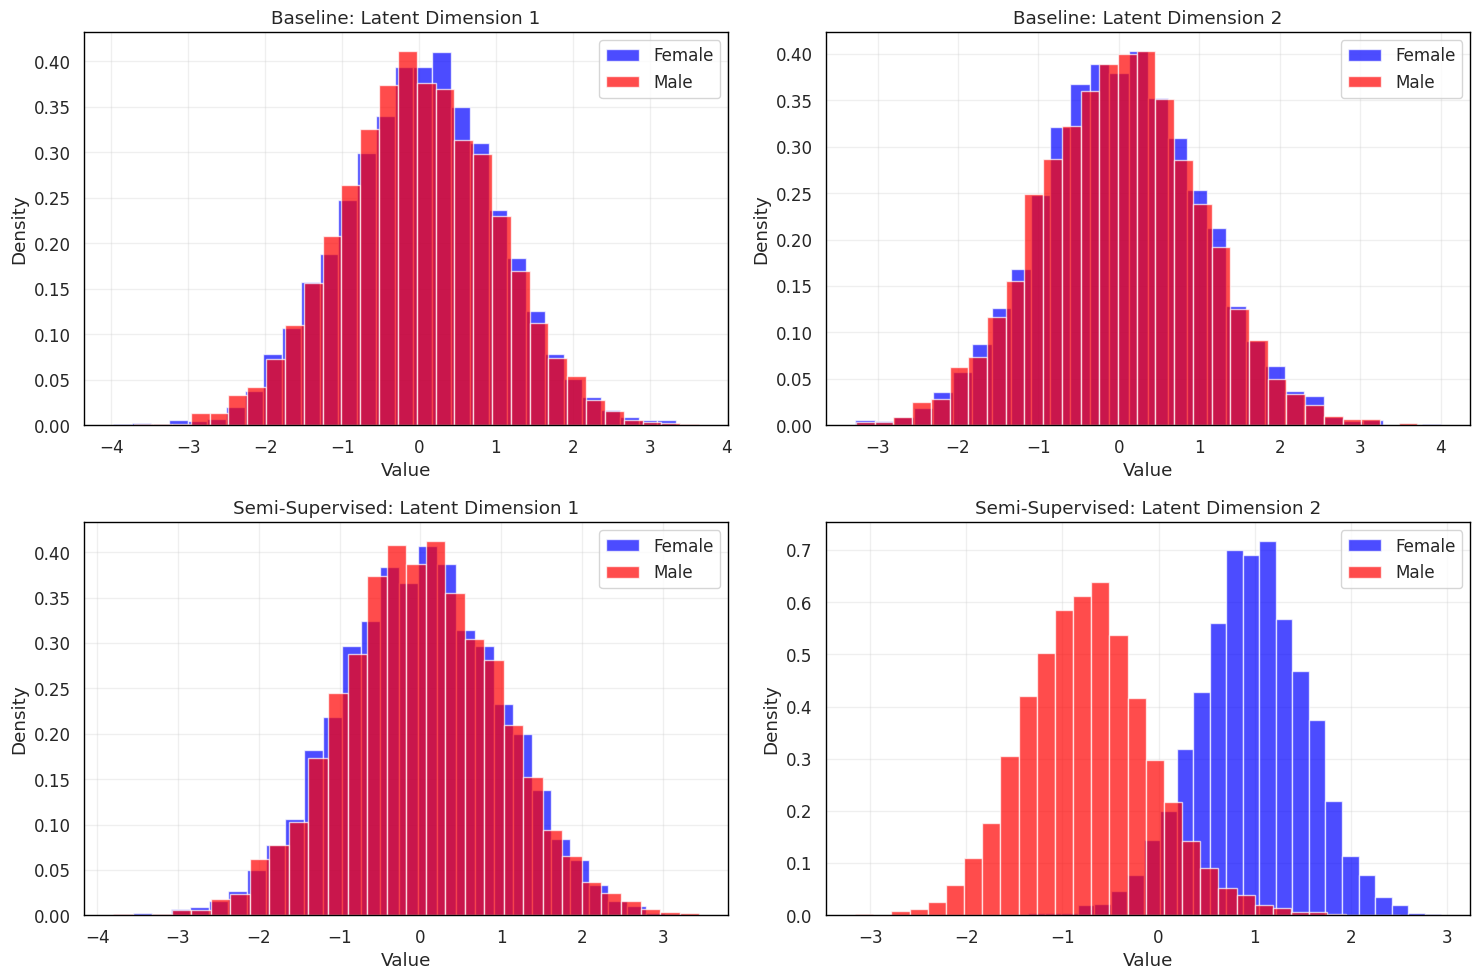

In [6]:
print("Analyzing learned latent representations...")

# Compare latent spaces
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Baseline latent space
if baseline_latent_a.shape[1] >= 2:
    female_mask = valid_genders == 0
    male_mask = valid_genders == 1

    axes[0].scatter(baseline_latent_a[female_mask, 0], baseline_latent_a[female_mask, 1],
                   c='blue', alpha=0.6, label='Female', s=20)
    axes[0].scatter(baseline_latent_a[male_mask, 0], baseline_latent_a[male_mask, 1],
                   c='red', alpha=0.6, label='Male', s=20)
    axes[0].set_title(f'Baseline VAE Latent Space\n(Accuracy: {baseline_accuracy:.3f})')
    axes[0].set_xlabel('Latent Dimension 1')
    axes[0].set_ylabel('Latent Dimension 2')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

# Semi-supervised latent space
if semi_latent_a.shape[1] >= 2:
    axes[1].scatter(semi_latent_a[female_mask, 0], semi_latent_a[female_mask, 1],
                   c='blue', alpha=0.6, label='Female', s=20)
    axes[1].scatter(semi_latent_a[male_mask, 0], semi_latent_a[male_mask, 1],
                   c='red', alpha=0.6, label='Male', s=20)
    axes[1].set_title(f'Semi-Supervised VAE Latent Space\n(Accuracy: {semi_accuracy:.3f})')
    axes[1].set_xlabel('Latent Dimension 1')
    axes[1].set_ylabel('Latent Dimension 2')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Distribution analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Baseline latent distributions
axes[0, 0].hist(baseline_latent_a[female_mask, 0], bins=30, alpha=0.7, label='Female', color='blue', density=True)
axes[0, 0].hist(baseline_latent_a[male_mask, 0], bins=30, alpha=0.7, label='Male', color='red', density=True)
axes[0, 0].set_title('Baseline: Latent Dimension 1')
axes[0, 0].set_xlabel('Value')
axes[0, 0].set_ylabel('Density')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

if baseline_latent_a.shape[1] >= 2:
    axes[0, 1].hist(baseline_latent_a[female_mask, 1], bins=30, alpha=0.7, label='Female', color='blue', density=True)
    axes[0, 1].hist(baseline_latent_a[male_mask, 1], bins=30, alpha=0.7, label='Male', color='red', density=True)
    axes[0, 1].set_title('Baseline: Latent Dimension 2')
    axes[0, 1].set_xlabel('Value')
    axes[0, 1].set_ylabel('Density')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

# Semi-supervised latent distributions
axes[1, 0].hist(semi_latent_a[female_mask, 0], bins=30, alpha=0.7, label='Female', color='blue', density=True)
axes[1, 0].hist(semi_latent_a[male_mask, 0], bins=30, alpha=0.7, label='Male', color='red', density=True)
axes[1, 0].set_title('Semi-Supervised: Latent Dimension 1')
axes[1, 0].set_xlabel('Value')
axes[1, 0].set_ylabel('Density')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

if semi_latent_a.shape[1] >= 2:
    axes[1, 1].hist(semi_latent_a[female_mask, 1], bins=30, alpha=0.7, label='Female', color='blue', density=True)
    axes[1, 1].hist(semi_latent_a[male_mask, 1], bins=30, alpha=0.7, label='Male', color='red', density=True)
    axes[1, 1].set_title('Semi-Supervised: Latent Dimension 2')
    axes[1, 1].set_xlabel('Value')
    axes[1, 1].set_ylabel('Density')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()